# Exploring the images in the dataset
Before training the models, we need to check that there are an even number of images accross the labels, otherwise it may introduce biases within the models, underfitting or overfitting a given label. To check this, we are going to count the number of images in each given folder and then plot on a graph to visualise whether descrepency across the labels is significant enough to deal with this issue.

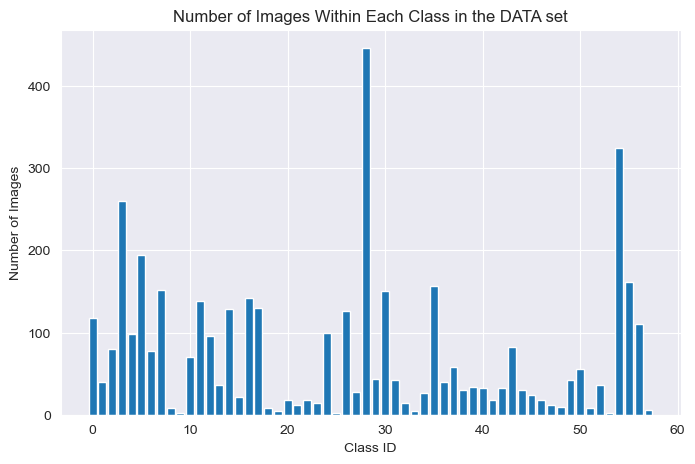

In [1]:
import os

from matplotlib import pyplot as plt

data_path = 'data/traffic_Data/DATA/' 

# Dictionary storing classes and the amount of images in each class
data_image_counts = {}
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        data_image_counts[class_id] = len(os.listdir(directory))
    
# Plotting the data for each class
plt.figure(figsize=(8, 5))
plt.bar(data_image_counts.keys(), data_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images Within Each Class in the DATA set')
plt.show()

# Descrepency in the amount of images in each class
As displayed in the two graphs above, there is an enormous difference between the class with the most number of training/testing images and the class with the least number of images. Therefore, we are going to use image augmentation to manipulate images in classes with a small sample to increase the number of samples, and thus creating a dataset with no bias.
# How image augmentation is going to be used on this dataset
## Figuring out the number of missing images
Before we use image augmentation, we need to figure out how many new images we are going to create. To do this, we need to find the difference between the class with the most images and the class with the least number of images; that will be the maximum number of images that will generated for a given class.

In [2]:
most_images = max(data_image_counts.values())
least_images = min(data_image_counts.values())
range_images = most_images - least_images
print(f"The difference between the class with the highest number of images and the class with the lowest number of images in DATA is {range_images}.")

The difference between the class with the highest number of images and the class with the lowest number of images in DATA is 444.


## Image augmentation techniques
Image augmentation provides various techniques amongst which:
- Motion blur: to simulate motion blur
- Color jittering: to get images at different brightness levels, contrast, and saturation
- Cropping: to get the road signs at different sizes 
- Perspective transformation: to simulate different angles on different road signs
- Salt-and-pepper Noise: to add random black and white dots to simulate dirt on the roadsigns

In [3]:
from math import ceil
max_augmentation = ceil(range_images/5)
print(f"The maximum number of images that will be generated using image augmentation for each technique will be {max_augmentation} images.")

The maximum number of images that will be generated using image augmentation for each technique will be 89 images.


In [4]:
import cv2 as cv#To import image and augment them
import numpy as np #To manipulate the pixel values of the images

### Motion blur
The first technique we want to implement is horizontal motion blur, as the models trained with this dataset would be essential for computer vision on electric cars. Therefore, when the car is in motion, the cameras capturing the environment around may experience horizontal motion blur, hence we believe that this dataset should be adjustest for such a occasion by training the models on images with this effect.

In [5]:
def motion_blur(img):
    kernel_size = np.random.randint(2, 15) 
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel /= kernel_size # Normalising the kernel
    return cv.filter2D(img, -1, kernel)

### Color jitter
This technique will simulate images with some noise. This noise in a car's camera may be due to damage, and will have to be accounted for when training the models.

In [6]:
def color_jitter(img):
    h, w, c = img.shape
    noise = np.random.randint(0, 50, (h,w)) # Creating noise
    jitter = np.zeros_like(img)
    jitter[:,:,1] = noise 
    return cv.add(img, jitter) # Applying noise to image

### Cropping
This transformation will allow the model to train with new examples from the original images. This helps the models generalise better and prevent them from overfitting to a specific spatial position.

In [7]:
def crop(img):
    h, w, c = img.shape
    # Maximum crop will be of 30% 
    # Does not crop the middle of the image because subject is in the middle
    x1 = np.random.randint(0, ceil(w*0.15))
    x2 = np.random.randint(w*0.85, w)
    y1 = np.random.randint(0, ceil(h*0.15))
    y2 = np.random.randint(h*0.85, h)
    return img[x1:x2, y1:y2]

### Perspective transformation 
In real life, cameras may capture road sign images at different angles. To simulate this situation, we are going to transform the perspective images in the dataset. Since they will usually be horizontally, I am going to focus on the horizontal perspectives.

In [8]:
def pt(img):
    h, w, c = img.shape
    # Getting random points on image
    x1 = np.random.randint(0, ceil(w*0.2))
    y1 = np.random.randint(0, ceil(h*0.2))
    
    x2 = np.random.randint(ceil(w*0.8), w)
    y2 = np.random.randint(0, ceil(h*0.2))
    
    x3 = np.random.randint(0, ceil(w*0.2))
    y3 = np.random.randint(ceil(h*0.8), h)
    
    x4 = np.random.randint(ceil(w*0.8), w)     
    y4 = np.random.randint(ceil(h*0.8), h)

    pts1 = np.float32([[x1, y1], [x2, y2], 
                       [x3, y3], [x4, y4]])
    pts2 = np.float32([[0, 0], [w, 0], 
                       [0, h], [w, h]])

    # Mapping pts2 onto pts1
    M = cv.getPerspectiveTransform(pts1,pts2)

    # Returning applied transformation
    return cv.warpPerspective(img,M,(w, h))

### Salt-and-pepper noise
Applying this noise to the images will simulate dirt being stuck on the road signs. Otherwise, there can be some dirt stuck on the camera itself, simulating the same effect.

In [9]:
def sap(img):  
    new_img = np.copy(img)
    h, w, c = img.shape 
      
    # Randomly picks a number of pixels between 300 and 1000 to colour in white
    number_of_pixels = np.random.randint(60, 150) 
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord = np.random.randint(0, h - 1) 
          
        # Pick a random x coordinate 
        x_coord = np.random.randint(0, w - 1) 
          
        # Color that pixel to white 
        new_img[y_coord][x_coord] = 255
          
    # Randomly picks a number of pixels between 300 and 1000 to colour in black
    number_of_pixels = np.random.randint(60, 200) 
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord = np.random.randint(0, h - 1) 
          
        # Pick a random x coordinate 
        x_coord = np.random.randint(0, w - 1) 
          
        # Color that pixel to black 
        new_img[y_coord][x_coord] = 0
          
    return new_img 

## Applying techniques to the dataset
Now that we have written a few algorithms for the differenct image augmentation techniques, we have to apply them to the classes with few images. Firstly, we are going to iterate through the folders and count how many images there are; if there are not enough images, we will generate them using the different techniques.

In [10]:
for i in range(58):
    imgs = []
    folder = data_path + str(i)
    # Reading all the images in each folder
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))

        if img is not None:
            imgs.append(img) # Adding to a list

    images2add = most_images - len(imgs)
    counter = 0

    # Applying filters if there are not enough images
    while images2add > 0:
        img = imgs[np.random.randint(len(imgs))]
        
        new_img = motion_blur(img)
        cv.imwrite(os.path.join(folder, f"motion_blur_{counter}.png"), new_img)
        images2add -= 1
        if images2add == 0:
            break

        new_img = color_jitter(img)
        cv.imwrite(os.path.join(folder, f"color_jitter{counter}.png"), new_img)
        images2add -= 1
        if images2add == 0:
            break

        new_img = crop(img)
        cv.imwrite(os.path.join(folder, f"crop_{counter}.png"), new_img)
        images2add -= 1
        if images2add == 0:
            break

        new_img = pt(img)
        cv.imwrite(os.path.join(folder, f"perspective_transformation_{counter}.png"), new_img)
        images2add -= 1
        if images2add == 0:
            break

        new_img = sap(img)
        cv.imwrite(os.path.join(folder, f"salt_and_pepper_{counter}.png"), new_img)
        images2add -= 1
        if images2add == 0:
            break

        counter += 1

# Conclusion
Now that there are equal number number of images across the dataset, the biases in the dataset have been removed.

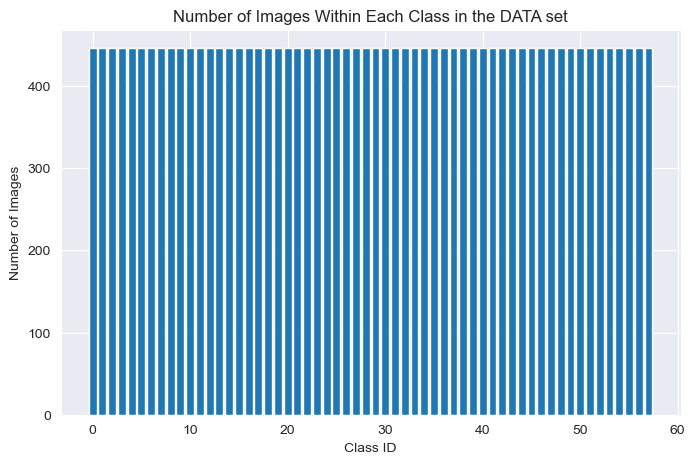

In [11]:
# Dictionary storing classes and the amount of images in each class
data_image_counts = {}
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        data_image_counts[class_id] = len(os.listdir(directory))
    
# Plotting the data for each class
plt.figure(figsize=(8, 5))
plt.bar(data_image_counts.keys(), data_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images Within Each Class in the DATA set')
plt.show()

Finally, I will also reduce each class size down to 200 to reduce the size of the dataset, which will speed up the model run-time as currently there are too many images to work with:

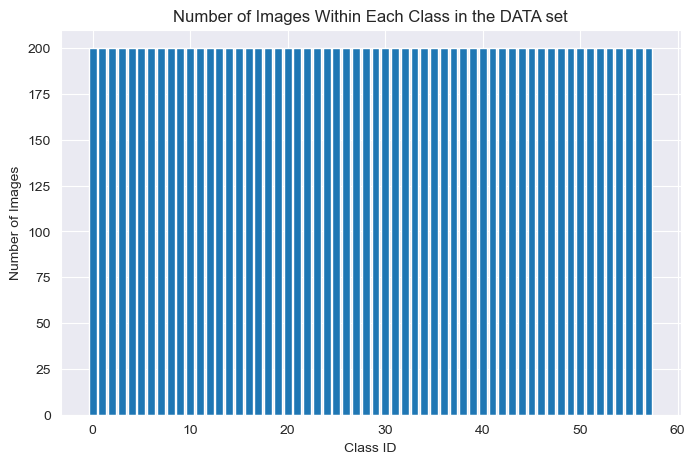

In [12]:

import os
from matplotlib import pyplot as plt

data_path = 'data/traffic_Data/DATA' 

for class_id in range(58):
    data_directory = os.path.join(data_path, str(class_id))
    if os.path.exists(data_directory):
        class_img_count = 0
        for img_file in os.listdir(data_directory):
            img_path = os.path.join(data_directory, img_file)
            if class_img_count >= 200:
                os.remove(img_path)
            class_img_count += 1

data_image_counts = {}
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        data_image_counts[class_id] = len(os.listdir(directory))
    
# Plotting the data for each class
plt.figure(figsize=(8, 5))
plt.bar(data_image_counts.keys(), data_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images Within Each Class in the DATA set')
plt.show()
